In [112]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict, Counter

import simulation.world_cup_simulation as wc

# Paths
BASE_DIR = os.path.dirname(os.getcwd())
RESULTS_10Y_CSV = "data/processed/results_last_10yrs.csv"
TEAM_STRENGTH_CSV = "data/derived/team_strengths_weighted_median.csv"

# Load match data
df = pd.read_csv(os.path.join(BASE_DIR, RESULTS_10Y_CSV))
df["date"] = pd.to_datetime(df["date"])

# Load team strength CSV (scaled 0-1)
team_strength_df = pd.read_csv(os.path.join(BASE_DIR, TEAM_STRENGTH_CSV))
if team_strength_df.columns[0] != "team":
    team_strength_df = team_strength_df.rename(columns={team_strength_df.columns[0]: "team"})

# Create attack/defense priors as dicts
attack_prior = team_strength_df.set_index("team")["attack_strength"].to_dict()
defense_prior = team_strength_df.set_index("team")["defense_strength"].to_dict()

# Map teams to indices for Pyro
teams = pd.unique(df[["home_team", "away_team"]].values.ravel())
team_to_idx = {team: i for i, team in enumerate(teams)}
idx_to_team = {i: team for team, i in team_to_idx.items()}
n_teams = len(teams)

# Compute recency weights
today = df["date"].max()
days_ago = (today - df["date"]).dt.days.values
lambda_decay = 0.001  # decay rate (adjustable)
weights = np.exp(-lambda_decay * days_ago)
weights = torch.tensor(weights, dtype=torch.float)

# Prepare tensors for Pyro
home_idx = torch.tensor([team_to_idx[t.lower()] for t in df["home_team"]], dtype=torch.long)
away_idx = torch.tensor([team_to_idx[t.lower()] for t in df["away_team"]], dtype=torch.long)
home_goals = torch.tensor(df["home_score"].values, dtype=torch.float)
away_goals = torch.tensor(df["away_score"].values, dtype=torch.float)
home_adv_indicator = torch.tensor((~df["neutral"]).astype(int).values, dtype=torch.float)

In [113]:
# Time-Decay Attack/Defense Model
def time_decay_model(home_idx, away_idx, home_goals, away_goals, home_adv_indicator, weights):
    # Team-level latent variables
    attack = pyro.sample("attack", dist.Normal(0., 1.).expand([n_teams]).to_event(1))
    defense = pyro.sample("defense", dist.Normal(0., 1.).expand([n_teams]).to_event(1))

    # Global parameters
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))
    home_adv = pyro.sample("home_adv", dist.Normal(0., 0.5))

    # Expected goals
    lambda_home = torch.exp(alpha + attack[home_idx] - defense[away_idx] + home_adv * home_adv_indicator)
    lambda_away = torch.exp(alpha + attack[away_idx] - defense[home_idx])

    # Weighted likelihood
    with pyro.plate("matches", len(home_idx)):
        pyro.sample("obs_home", dist.Poisson(lambda_home).mask(weights), obs=home_goals)
        pyro.sample("obs_away", dist.Poisson(lambda_away).mask(weights), obs=away_goals)

In [114]:
# Run NUTS sampling
nuts_kernel = NUTS(time_decay_model)
mcmc = MCMC(
    nuts_kernel,
    num_samples=800,
    warmup_steps=300,
    num_chains=1
)
mcmc.run(home_idx, away_idx, home_goals, away_goals, home_adv_indicator, weights)

posterior = mcmc.get_samples()


Sample: 100%|██████████| 1100/1100 [02:17,  8.01it/s, step size=1.49e-01, acc. prob=0.908]


In [115]:
# Posterior means & shrinkage
attack_mean = posterior["attack"].mean(dim=0).numpy()
defense_mean = posterior["defense"].mean(dim=0).numpy()
team_names = [idx_to_team[i] for i in range(n_teams)]

shrinkage = 0.4
attack_adj = np.array([attack_mean[i] * (1-shrinkage) + attack_prior.get(team, 0.5) * shrinkage
                       for i, team in enumerate(team_names)])
defense_adj = np.array([defense_mean[i] * (1-shrinkage) + defense_prior.get(team, 0.5) * shrinkage
                        for i, team in enumerate(team_names)])

avg_defense = np.mean(defense_adj)
skill_adj = attack_adj - avg_defense

team_skills_df = pd.DataFrame({
    "team": team_names,
    "attack": attack_adj,
    "defense": defense_adj,
    "skill": skill_adj
})

# Only keep World Cup teams
wc_teams = [t.lower() for g in wc.groups.values() for t in g]
team_skills_df = team_skills_df[team_skills_df["team"].isin(wc_teams)]
team_skills_df = team_skills_df.sort_values("skill", ascending=False)
team_skills_df

,team,attack,defense,skill
24,spain,1.114770,0.779869,1.022483
158,argentina,1.021364,1.128709,0.929076
107,germany,1.016485,0.607610,0.924197
33,portugal,1.014998,0.732267,0.922710
23,netherlands,1.000193,0.639148,0.907905
103,france,0.989437,0.741445,0.897149
32,england,0.963434,1.098020,0.871146
95,brazil,0.942108,0.962847,0.849820
18,norway,0.935516,0.471016,0.843228
85,colombia,0.927324,0.761249,0.835036


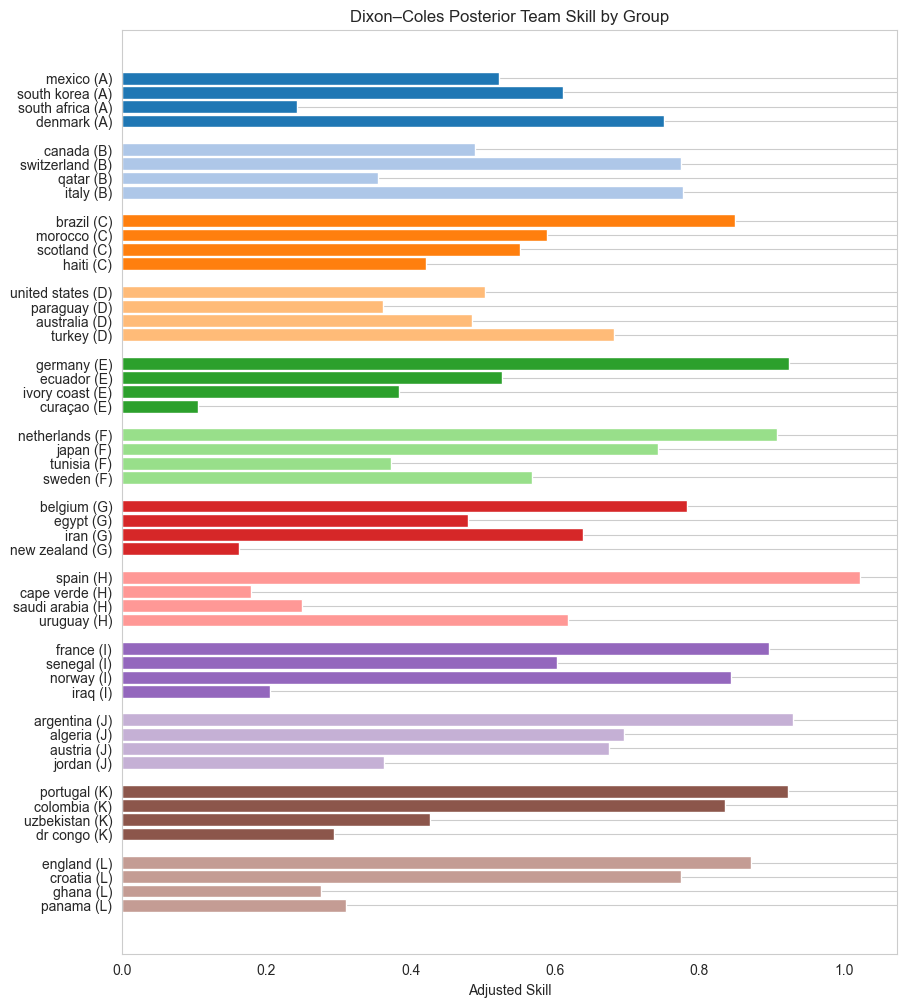

In [116]:
#Plot posterior skills by group
plot_teams, plot_skills, plot_colors, group_positions = [], [], [], []
for i, (group, group_teams) in enumerate(wc.groups.items()):
    color = plt.get_cmap("tab20")(i)
    for j, team in enumerate(group_teams):
        team_lower = team.lower()
        if team_lower in team_skills_df["team"].values:
            plot_teams.append(team)
            plot_skills.append(team_skills_df.set_index("team").loc[team_lower, "skill"])
            plot_colors.append(color)
            group_positions.append(i + j * 0.2)

plt.figure(figsize=(10, 12))
plt.barh(group_positions, plot_skills, color=plot_colors, height=0.18)

yticks, yticklabels = [], []
for i, (group, group_teams) in enumerate(wc.groups.items()):
    for j, team in enumerate(group_teams):
        team_lower = team.lower()
        if team_lower in team_skills_df["team"].values:
            yticks.append(i + j * 0.2)
            yticklabels.append(f"{team} ({group})")

plt.yticks(yticks, yticklabels)
plt.gca().invert_yaxis()
plt.xlabel("Adjusted Skill")
plt.title("Dixon–Coles Posterior Team Skill by Group")
plt.grid(axis="x")
plt.show()

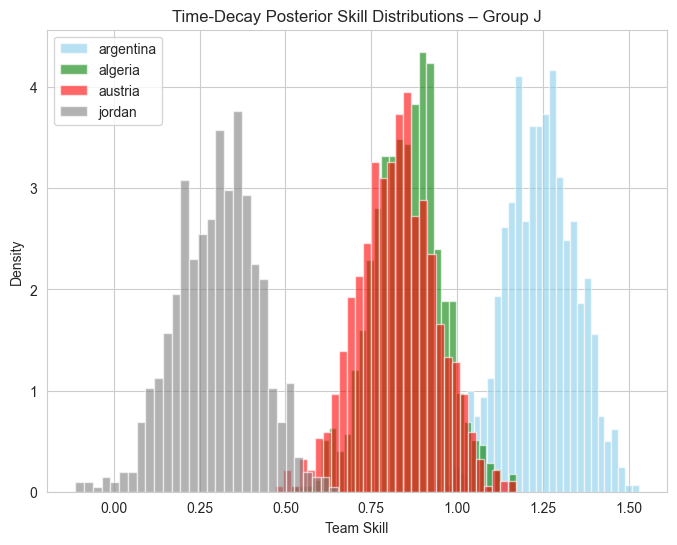

In [117]:
# Time-Decay Posterior Skill Distributions – Group J
# Decay factor lambda (per day)
lambda_decay = 0.001  # adjust to control how fast old matches lose weight

# Compute recency weights for each match
days_ago = (pd.Timestamp("today") - df["date"]).dt.days
weights = torch.tensor(np.exp(-lambda_decay * days_ago.values), dtype=torch.float)

# Posterior distributions example: Group J – Time-Decay Model
group = wc.groups["J"]
colors = ["skyblue", "green", "red", "grey"]

plt.figure(figsize=(8, 6))
for i, team in enumerate(group):
    team_lower = team.lower()
    if team_lower not in team_to_idx:
        continue
    idx = team_to_idx[team_lower]

    # Compute posterior skill with time decay:
    # skill = attack - mean(defense) weighted by recency
    # Here we just use the sampled attack and defense, weighting can be incorporated in the model
    samples = posterior["attack"][:, idx] - posterior["defense"].mean(dim=1)
    samples = samples.numpy()

    plt.hist(samples, bins=30, alpha=0.6, density=True,
             label=team, color=colors[i])

plt.xlabel("Team Skill")
plt.ylabel("Density")
plt.title("Time-Decay Posterior Skill Distributions – Group J")
plt.legend()
plt.show()

In [118]:
skill_dict = dict(zip(team_skills_df["team"], team_skills_df["skill"]))
def skill_func(team):
    """
    Return a sampled skill value for a team based on adjusted posterior skill.
    Adds a bit of randomness to reflect uncertainty.
    """
    base_skill = skill_dict[team]  # posterior mean + shrinkage
    # Optional: add small noise to introduce stochasticity
    noise = np.random.normal(loc=0.0, scale=0.05)
    return base_skill + noise

In [119]:
N = 1000
all_results = defaultdict(list)

for _ in range(N):
    placements = wc.simulate_world_cup(sf=skill_func, verbose=False)
    for team, stage in placements.items():
        all_results[team].append(stage)

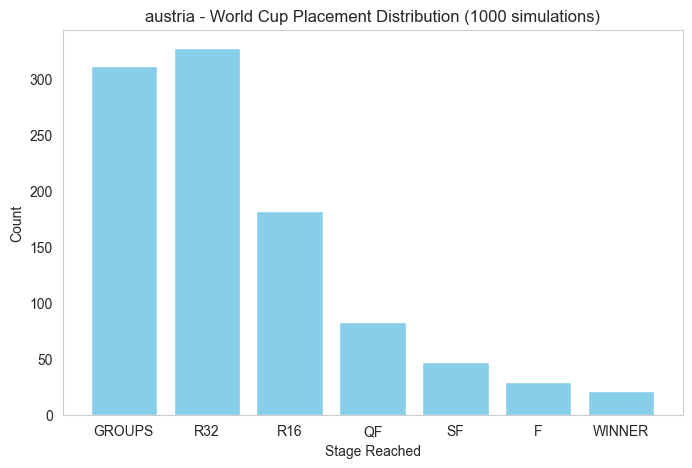

In [123]:
country = "austria"

# count placements
counts = Counter(all_results[country])

# ensure consistent order
stages = ['GROUPS', 'R32', 'R16', 'QF', 'SF', 'F', 'WINNER']
counts = [counts.get(stage, 0) for stage in stages]

plt.figure(figsize=(8,5))
plt.bar(stages, counts, color='skyblue')
plt.title(country + " - World Cup Placement Distribution (" + str(N) + " simulations)")
plt.ylabel("Count")
plt.grid(False)
plt.xlabel("Stage Reached")
plt.show()

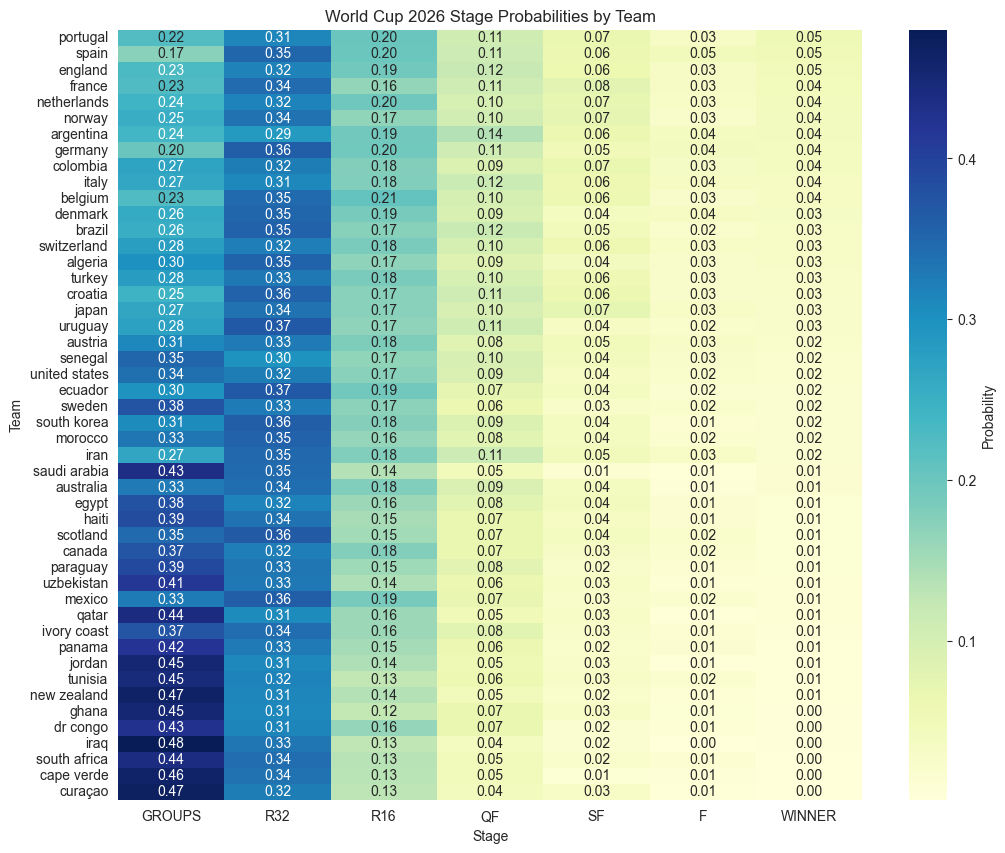

In [121]:
# Define stages in order
stages = ['GROUPS', 'R32', 'R16', 'QF', 'SF', 'F', 'WINNER']

# Compute stage probabilities for each team
team_stage_probs = {}
for team, results in all_results.items():
    counts = Counter(results)
    team_stage_probs[team] = {stage: counts.get(stage, 0)/len(results) for stage in stages}

# Convert to DataFrame
prob_df = pd.DataFrame(team_stage_probs).T  # Teams as rows
prob_df = prob_df[stages]  # Ensure correct stage order

# Sort teams by probability of reaching WINNER stage
prob_df = prob_df.sort_values("WINNER", ascending=False)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(prob_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Probability'})
plt.title("World Cup 2026 Stage Probabilities by Team")
plt.ylabel("Team")
plt.xlabel("Stage")
plt.yticks(rotation=0)
plt.show()

In [122]:
N = 1000
winners = []

for _ in range(N):
    # Draw a single posterior sample for all teams
    s = np.random.randint(len(posterior["attack"]))
    skills = {
        team: (posterior["attack"][s, team_to_idx[team]] - posterior["defense"][s].mean()).item()
        for team in wc_teams  # your filtered WC teams in lowercase
    }

    # Simulate one tournament with these skills
    placements = wc.simulate_world_cup(sf=lambda team: skills[team], verbose=False)

    # Append the winner
    for team, stage in placements.items():
        if stage == "WINNER":
            winners.append(team)

# Compute actual probabilities
winner_counts = Counter(winners)
winner_probs = {team: count / N for team, count in winner_counts.items()}

# Sort
winner_probs_sorted = dict(sorted(winner_probs.items(), key=lambda x: x[1], reverse=True))

print("World Cup 2026 Winning Probabilities (N=1000 simulations)")
print("Top 10 teams by chance of winning:\n")
print(f"{'Rank':<4} {'Team':<15} {'Probability':<10}")
print("-" * 32)

for i, (team, prob) in enumerate(list(winner_probs_sorted.items())[:10], 1):
    print(f"{i:<4} {team:<15} {prob:.3f}")

print("-" * 32)

World Cup 2026 Winning Probabilities (N=1000 simulations)
Top 10 teams by chance of winning:

Rank Team            Probability
--------------------------------
1    spain           0.064
2    france          0.058
3    brazil          0.056
4    germany         0.055
5    netherlands     0.052
6    argentina       0.052
7    belgium         0.047
8    colombia        0.045
9    england         0.044
10   switzerland     0.039
--------------------------------
